# Scala MicroGrad Plain Code

In [16]:
import math
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [22]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self.prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(label={self.label} data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _children=(self, other), _op='+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _children=(self, other), _op='*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only support int/float powers for now"
        out = Value(self.data ** other, _children=(self,), _op=f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other):
        return self * other ** -1
    
    def exp(self):
        out = Value(math.exp(self.data), _children=(self,), _op='exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        out = Value((math.exp(2 * self.data) - 1)  / (math.exp(2 * self.data) + 1), _children=(self,), _op='tanh')

        def _backward():
            self.grad += (1 - out.data ** 2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        visited = set()
        order = []
        def topology_sort(root):
            if root not in visited:
                visited.add(root)
                for child in root.prev:
                    topology_sort(child)
                order.append(root)

        topology_sort(self)
        self.grad = 1.0
        for node in order[::-1]:
            node._backward()   
        

In [18]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for node in nodes:
        uid = str(id(node))
        dot.node(uid, label="{ %s | data %.4f | grad %.4f }" % (node.label, node.data, node.grad), shape='record')
        if node._op:
            dot.node(name=uid + node._op, label=node._op)
            dot.edge(uid + node._op, uid)
    for child, node in edges:
        dot.edge(str(id(child)), str(id(node)) + node._op)
        

    return dot

In [19]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a * b
d = e + c
d.label = 'd'
e.label = 'e'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'


In [20]:
# manual backpropriation - chain rule
L.grad = 1.0
# dL/dd = dL * f
d.grad = L.grad * f.data
# dL/df = dL * d
f.grad = L.grad * d.data
# dL/dc = dL/dd * dd/dc = dL/dd * 1
c.grad = d.grad * 1.0
# dL/de = dL/dd * dd/de = dL/dd * 1
e.grad = d.grad * 1.0 
# dL/da = dL/dd * dd/de * de/da = dl/de * b
a.grad = e.grad * b.data
# dL/db = dL/dd * dd/de * de/db = dL/de * a
b.grad = e.grad * a.data

In [128]:
# auto backpropagation
L.backward()

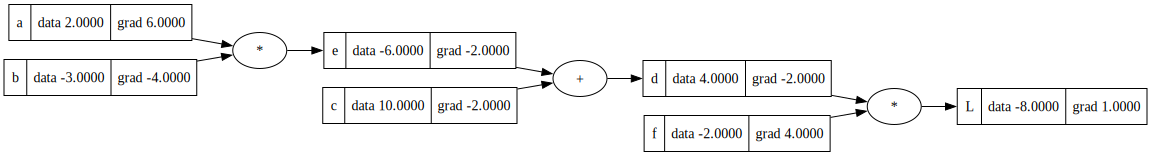

In [129]:
draw_dot(L)

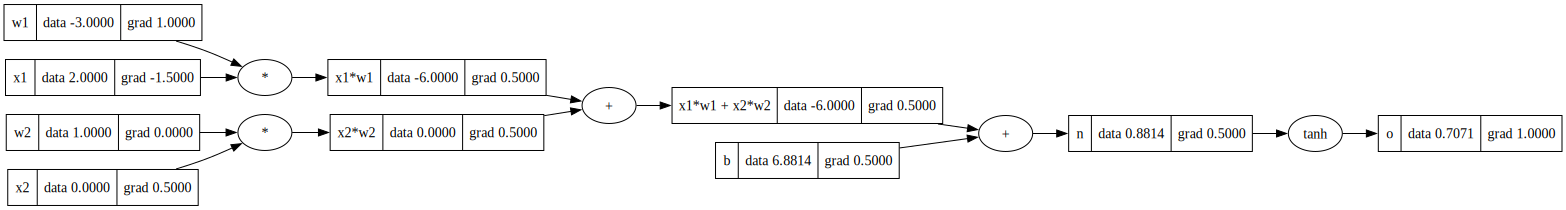

In [25]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')
# x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1
x1w1.label = 'x1*w1'
x2w2 = x2 * w2
x2w2.label = 'x2*w2'
x1w1_x2w2 = x1w1 + x2w2
x1w1_x2w2.label = 'x1*w1 + x2*w2'
n = x1w1_x2w2 + b
n.label = 'n'
# tanh activation
o = n.tanh()
o.label = 'o'
o.backward()
draw_dot(o)

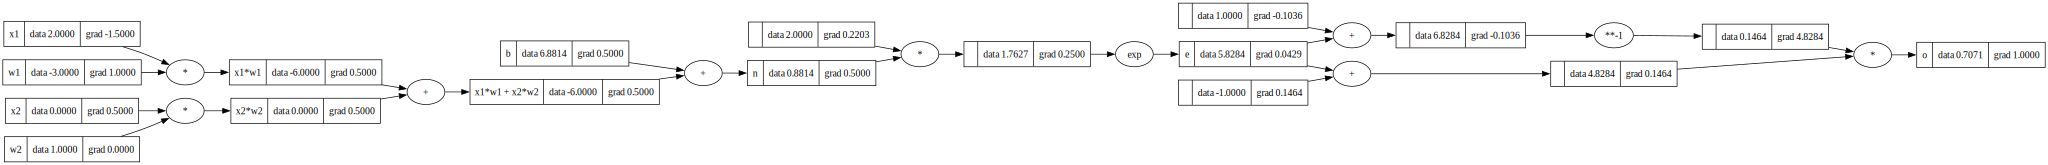

In [24]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')
# x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1
x1w1.label = 'x1*w1'
x2w2 = x2 * w2
x2w2.label = 'x2*w2'
x1w1_x2w2 = x1w1 + x2w2
x1w1_x2w2.label = 'x1*w1 + x2*w2'
n = x1w1_x2w2 + b
n.label = 'n'
# tanh activation
e = (2 * n).exp()
e.label = 'e'
o = (e - 1) / (e + 1)
o.label = 'o'
o.backward()
draw_dot(o)

# Pytorch

In [26]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() 
b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("-------------------")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
-------------------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
print(o.data.item())
o.backward()

print("-------------------")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

# Simple Neural Network based on Self Defined Value

## Single Neuron

In [75]:
import random

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        act = sum([wi * xi for wi, xi in zip(self.w, x)], self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(label= data=0.5812490536510716)

## Neural Network Layer of Neuron
a set of neurons that act independently

In [76]:
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
L = Layer(2, 3)
x = [2.0, 3.0]
L(x)

[Value(label= data=-0.9999467294768923),
 Value(label= data=-0.9100268989946322),
 Value(label= data=0.9182807981600916)]

## Multiple Layers Neural Networks

In [77]:
class MLP:

    def __init__(self, nin, nouts):
        layer_sizes = [nin] + nouts
        self.layers = [Layer(layer_sizes[i], layer_sizes[i + 1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
mlp(x)

Value(label= data=-0.018616292631046572)

In [78]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [mlp(x) for x in xs]
ypred

[Value(label= data=-0.018616292631046572),
 Value(label= data=-0.899573599913282),
 Value(label= data=-0.19728306562227896),
 Value(label= data=0.3229547880366098)]

In [79]:
loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)], Value(0.0))
loss

Value(label= data=2.150409309227114)

In [80]:
loss.backward()

In [81]:
mlp.layers[0].neurons[0].w[0].grad  

-0.18581213571715455

In [82]:
mlp.parameters()

[Value(label= data=-0.2759787540291003),
 Value(label= data=0.35382798821924055),
 Value(label= data=-0.19547465677520615),
 Value(label= data=0.8044149037709973),
 Value(label= data=-0.6390692802113356),
 Value(label= data=0.7987232401499558),
 Value(label= data=-0.48320429092716544),
 Value(label= data=0.10371933850432424),
 Value(label= data=-0.7524785350948586),
 Value(label= data=-0.07070696470520277),
 Value(label= data=-0.35809268634246294),
 Value(label= data=0.8229715589132487),
 Value(label= data=0.2789303316601248),
 Value(label= data=-0.7330808689968347),
 Value(label= data=0.623877824311073),
 Value(label= data=0.6946940912549815),
 Value(label= data=0.2734812874420487),
 Value(label= data=-0.8151562015430593),
 Value(label= data=0.7632405933340936),
 Value(label= data=-0.061026048719726056),
 Value(label= data=0.6103373835152419),
 Value(label= data=0.34171435385969495),
 Value(label= data=-0.7095149103648095),
 Value(label= data=0.11387226380351945),
 Value(label= data=0